# Richards equation

In this tutorial we present how to solve a Richards equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unkwons are the velocity $q$ and the pressure $p$.

Let $\Omega=(0,1)\times(0,1)$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Given 
$k$ the matrix permeability, we want to solve the following problem: find $({q}, \psi)$ such that
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q} + \nabla \psi = -\nabla z\\
\partial_t \theta (\psi) + \nabla \cdot {q} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
with boundary conditions:

$$ \psi = 0 \text{ on } \partial_{top} \Omega \qquad \psi = 1 \text{ on } \partial_{bottom} \Omega \qquad \nu \cdot q = 0 \text{ on } \partial_{left} \Omega \cup \partial_{right} \Omega$$

and with:

$$ K = I, \qquad \theta(\psi) = 
\left\{
\begin{array}{ll}
\begin{array}{l} 
0.8, \text{ if } \psi^2 > 0.8\\
0.2, \text{ if } \psi^2 < 0.2\\
\psi^2,  \text{ otherwise }
\end{array}
\end{array}
\right.
, \qquad \psi(t=0)=0 $$

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

### Import and parameters

In [1]:
import shutil
import os

import numpy as np
import scipy.sparse as sps
import sympy as sp

import porepy as pp
import pygeon as pg

from math import ceil, floor, log10, exp

import matplotlib.pyplot as plt

In [2]:
K = 50
N = 10

eps_psi_abs = 1e-5
eps_psi_rel = 1e-5

domain_tolerance = 1 / (10 * N)
beta_q   = 0
beta_psi = 0

output_directory = 'output_evolutionary'

In [3]:
rho = 1000
g = pp.GRAVITY_ACCELERATION

In [4]:
dt_D = 1/16
dt   = 1/48
T    = 3/16

### $\theta$ and $k$, with their derivatives w.r.t. $\psi$

In [5]:
def theta(psi):
    return np.minimum(np.maximum(np.power(psi, 2), 0.2), 0.8)

In [6]:
def quick_plot():
    psi_val = np.linspace(0, 1, 100)
    theta_val = theta(psi_val)

    _, (ax1) = plt.subplots(1, 1, figsize=(10, 5))

    ax1.plot(psi_val, theta_val)
    ax1.set_title("theta")

    plt.show()

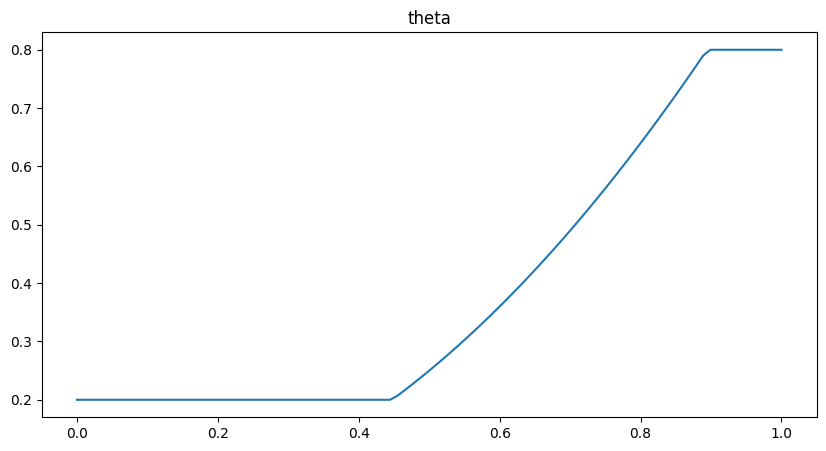

In [7]:
quick_plot()

### Domain preparation

In [8]:
subdomain = pp.StructuredTriangleGrid([N, N], [1,1])
# convert the grid into a mixed-dimensional grid
mdg = pp.meshing.subdomains_to_mdg([subdomain])

/home/faccus/.local/lib/python3.10/site-packages/porepy/viz/plot_grid.py:198: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_zlim3d(z)


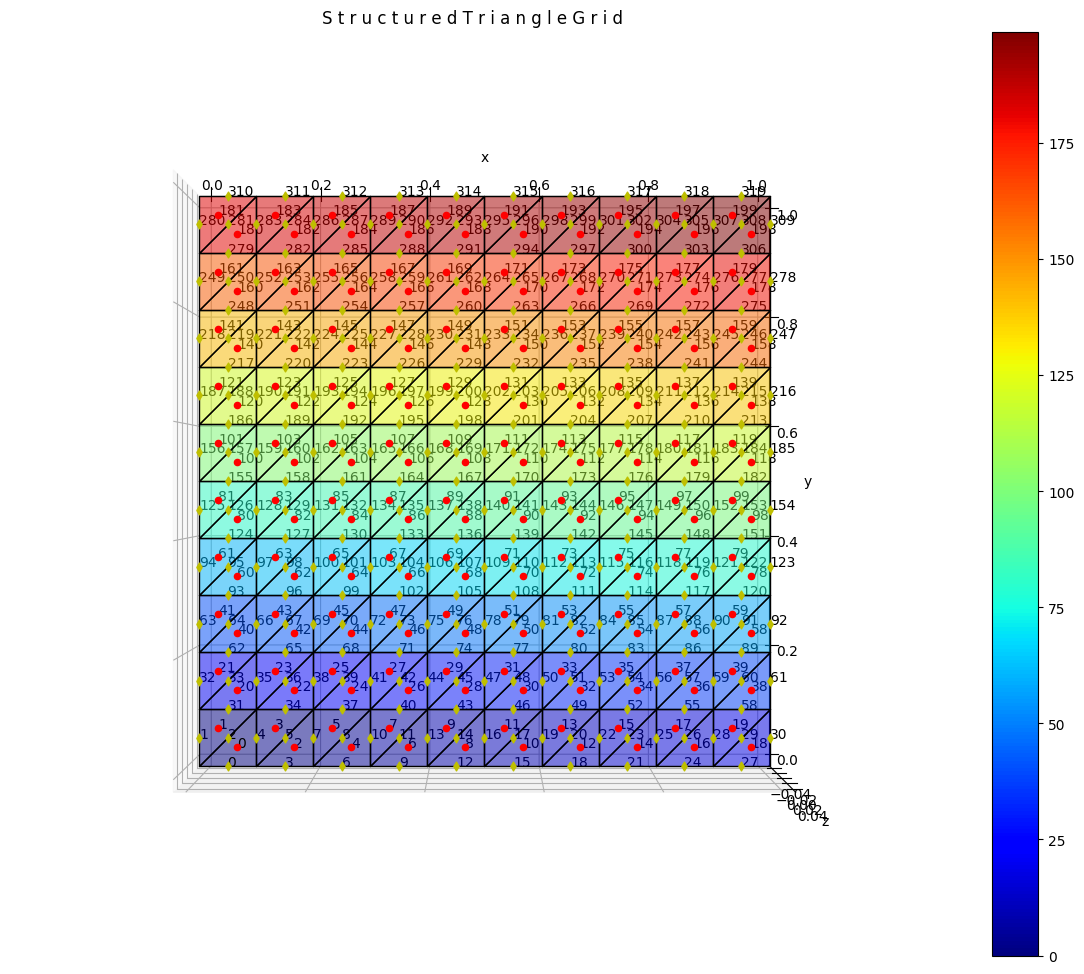

In [9]:
pp.plot_grid(subdomain, cell_value=np.arange(subdomain.num_cells), info='cf', alpha=0.5, figsize=(15,12))

In [10]:
key = "flow"

bc_value = []
bc_essential = []
initial_pressure = []

gravity = []

RT0 = pg.RT0(key)
P0  = pg.PwConstants(key)

In [11]:
def g_func(x): 
    return np.array([0, -1, -1])

In [12]:
def initial_pressure_func(x): 
    return x[1]

In [13]:
for subdomain, data in mdg.subdomains(return_data=True):
    g_proj = RT0.interpolate(subdomain, g_func)
    gravity.append(RT0.assemble_mass_matrix(subdomain) @ g_proj)
    
    initial_pressure.append(P0.interpolate(subdomain, initial_pressure_func))
        
    # with the following steps we identify the portions of the boundary
    # to impose the boundary conditions

    left_right = np.logical_or(subdomain.face_centers[0, :] < 0+domain_tolerance,  subdomain.face_centers[0, :] > 1-domain_tolerance)

    bottom = subdomain.face_centers[1, :] < 0+domain_tolerance
    top    = subdomain.face_centers[1, :] > 1-domain_tolerance

    ess_p_dofs = np.zeros(P0.ndof(subdomain), dtype=bool)

    def p_bc(x): return 1

    bc_value.append(-RT0.assemble_nat_bc(subdomain, p_bc, bottom))
    bc_essential.append(np.hstack((left_right, ess_p_dofs)))

A quick recap:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q} + \nabla \psi = -\nabla z\\
\partial_t \theta (\psi) + \nabla \cdot {q} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
becames, with the time discretization:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q^{n+1}} + \nabla \psi^{n+1} = -\nabla z\\
\frac{\theta (\psi^{n+1}) - \theta (\psi^{n})}{\Delta t} + \nabla \cdot {q^{n+1}} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$

$$
Picard \qquad
\left\{
\begin{array}{ll}
\begin{array}{l} 
(M^{n+1}_k + \beta_{q} M) q_{k+1}^{n+1} + B^T \psi^{n+1}_{k+1} = G^{n+1} + \beta_{q} M q_{k}^{n+1}\\
-B q_{k+1}^{n+1} + \beta_{\psi} E \psi_{k+1}^{n+1} = \beta_{\psi} E \psi_{k}^{n+1} + \frac{\Theta^n - \Theta^{n+1}_k}{\Delta t} + F^{n+1}
\end{array}
\end{array}
\right.
$$
where:
$$
[M^{n+1}_k]_{ij} = \left( K^{-1}(\psi^{n+1}_k) \Phi_j, \Phi_i \right)_{L^2(\Omega)}, \qquad [\Theta^n]_{i} = \left( \frac{\theta(\psi^n)}{\Delta t}, \Psi_i \right)_{L^2(\Omega)}, \qquad [\Theta^{n+1}_k]_{i} = \left( \frac{\theta(\psi^{n+1}_k)}{\Delta t}, \Psi_i \right)_{L^2(\Omega)}, \qquad [B]_{ij} = - \left( \Psi_i, \nabla \cdot \Phi_j \right)_{L^2(\Omega)}, \qquad [E]_{ij} = \left( \Psi_i, \Psi_j \right)_{L^2(\Omega)}, \qquad [M]_{ij} = \left( \Phi_j, \Phi_i \right)_{L^2(\Omega)}
$$


$$
Netwon \qquad
\left\{
\begin{array}{ll}
\begin{array}{l} 
M^{n+1}_k q_{k+1}^{n+1} + [B^T + C(\psi_k^{n+1}, q_ {k}^{n+1})] \psi^{n+1}_{k+1} = G^{n+1} + C(\psi_k^{n+1}, q_ {k}^{n+1}) \psi_k^{n+1} + BC^{n+1}\\
\frac{1}{\Delta t} D(\psi_{k}^{n+1}) \psi_{k+1}^{n+1} -B q_{k+1}^{n+1} = \frac{\Theta^n - \Theta^{n+1}_k}{\Delta t} + \frac{1}{\Delta t} D(\psi_{k}^{n+1}) \psi_{k}^{n+1} + F^{n+1}
\end{array}
\end{array}
\right.
$$
where:
$$
[C(\psi_k^{n+1}, q_ {k}^{n+1})]_{ij} = \int_{\Omega} \Psi_j \frac{\partial K^{-1}(\psi_k^{n+1})}{\partial \psi} \, q_k^{n+1} \cdot \Phi_i \, d\Omega = \alpha_j \int_{\omega_j} \frac{q_k^{n+1} \cdot \Phi_i}{k(\psi_k^{n+1})} \, d\Omega \qquad [D(\psi_{k}^{n+1})]_{ij} = \left( \frac{\partial \theta}{\partial \psi}(\psi_k^{n+1}) \Psi_j, \Psi_i \right)_{L^2(\Omega)}
$$

In [14]:
div = -pg.cell_mass(mdg) @ pg.div(mdg)

# get the degrees of freedom for each variable
dof_p, dof_q = div.shape
dof_psi = dof_p

In [15]:
dof_p, dof_q

(200, 320)

In [16]:
proj_q   = RT0.eval_at_cell_centers(subdomain)
proj_psi =  P0.eval_at_cell_centers(subdomain)


def export_step(save, current_sol, step) -> None:
    q   = current_sol[:dof_q]
    psi = current_sol[-dof_psi:]

    ins = list()

    for sub, _ in mdg.subdomains(return_data=True):
        ins.append((sub, "cell_q", ( proj_q @ q).reshape((3, -1), order="F")))
        ins.append((sub, "cell_p", proj_psi @ psi))
    
    save.write_vtu(ins, time_step=step)

In [17]:
Mass_q   = RT0.assemble_mass_matrix(subdomain)
Mass_psi = pg.cell_mass(mdg)

def picard(sol_n, t_n_1, prev=None, iters=K, debug=False):
    if prev == None:
        prev = sol_n.copy()


    # assemble the right-hand side
    fixed_rhs = np.zeros(dof_psi + dof_q)

    # Theta^n
    fixed_rhs[-dof_psi:] += Mass_psi @ (theta(proj_psi @ prev[-dof_psi:]) * subdomain.cell_volumes) / dt

    # Natural BCs
    fixed_rhs[:dof_q] += np.hstack(bc_value)

    # Gravity
    fixed_rhs[:dof_q] += np.hstack(gravity)

    if debug:
        save_debug = pp.Exporter(mdg, "sol_" + str(t_n_1), folder_name=output_directory + "/debug")
        export_step(save_debug, prev, 0)

    print('Time ' + str(round(t_n_1, 5)))

    for k in range(iters):

        rhs = None
        rhs = fixed_rhs.copy()

        # Theta^{n+1}_k
        rhs[-dof_psi:] -= Mass_psi @ (theta(proj_psi @ prev[-dof_psi:]) * subdomain.cell_volumes) / dt

        rhs[-dof_psi:] += beta_psi * Mass_psi @ prev[-dof_psi:]
        rhs[:dof_q]    += beta_q   * Mass_q   @ prev[:dof_q]

        
        spp = sps.bmat([[(1 + beta_q) * Mass_q,               div.T], 
                        [-div,                  beta_psi * Mass_psi]], format="csc")
        

        
        # solve the problem
        ls = None
        ls = pg.LinearSystem(spp, rhs)
        ls.flag_ess_bc(np.hstack(bc_essential), np.zeros(dof_q + dof_psi))
    
        current = None
        current = ls.solve()

        if debug:
            export_step(save_debug, current, k+1)


        abs_err_psi  = np.sqrt(np.sum(np.power(current[-dof_psi:]-prev[-dof_psi:], 2)))
        abs_err_prev = np.sqrt(np.sum(np.power(prev[-dof_psi:], 2)))


        print('Iteration #' + format(k+1, '0' + str(ceil(log10(iters)) + 1) + 'd') 
              + ', error L2 relative psi: ' + format(abs_err_psi, str(5 + ceil(log10(1 / eps_psi_abs)) + 4) + '.' + str(ceil(log10(1 / eps_psi_abs)) + 4) + 'f'))

        if abs_err_psi < eps_psi_abs + eps_psi_rel * abs_err_prev:
            print('')
            return current
        else:
            prev = current
    return current

In [18]:
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

In [19]:
# assemble initial solution
initial_solution = np.zeros(dof_q + dof_psi)
#initial_solution[-dof_psi:] += np.hstack(initial_pressure)

In [20]:
sol = [initial_solution]
save = pp.Exporter(mdg, "sol", folder_name=output_directory)
export_step(save, sol[-1], 0)

# Time Loop
for step in range(1, ceil(T/dt)+1):
    sol.append( picard(sol[-1], step * dt, debug=True) )
    export_step(save, sol[-1], step)

save.write_pvd(np.array(range(0, ceil(T/dt)+1)) * dt)

Time 0.02083
Iteration #001, error L2 relative psi:    0.040790794
Iteration #002, error L2 relative psi:    0.046191977
Iteration #003, error L2 relative psi:    0.044908153
Iteration #004, error L2 relative psi:    0.039721028
Iteration #005, error L2 relative psi:    0.039445142
Iteration #006, error L2 relative psi:    0.038327465
Iteration #007, error L2 relative psi:    0.038261720
Iteration #008, error L2 relative psi:    0.038002058
Iteration #009, error L2 relative psi:    0.037984711
Iteration #010, error L2 relative psi:    0.037916271
Iteration #011, error L2 relative psi:    0.037911688
Iteration #012, error L2 relative psi:    0.037893611
Iteration #013, error L2 relative psi:    0.037892399
Iteration #014, error L2 relative psi:    0.037887622
Iteration #015, error L2 relative psi:    0.037887302
Iteration #016, error L2 relative psi:    0.037886040
Iteration #017, error L2 relative psi:    0.037885955
Iteration #018, error L2 relative psi:    0.037885622
Iteration #019,